# Libraries, Modules, and Configuration File

In [2]:
import pandas as pd
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime
from tqdm import tqdm
import json
import copy
import hashlib

import sys
sys.path.append('/root/ml_process_feb23/')
import src.util as utils
config = utils.load_config()

# Load the Datasets

In [159]:
def load_datasets(config):

    df_train = utils.pkl_load(config['dataset_modelling_path'][0])
    x_train = df_train.drop(['card'], axis = 1)
    y_train = df_train['card']

    df_valid = utils.pkl_load(config['dataset_modelling_path'][1])
    x_valid = df_valid.drop(['card'], axis = 1)
    y_valid = df_valid['card']

    df_test = utils.pkl_load(config['dataset_modelling_path'][2])
    x_test = df_test.drop(['card'], axis = 1)
    y_test = df_test['card']

    x_train_rus = utils.pkl_load(config["dataset_train_balanced_path"][0])
    y_train_rus = utils.pkl_load(config["dataset_train_balanced_path"][1])

    x_train_ros = utils.pkl_load(config["dataset_train_balanced_path"][2])
    y_train_ros = utils.pkl_load(config["dataset_train_balanced_path"][3])

    x_train_smote = utils.pkl_load(config["dataset_train_balanced_path"][4])
    y_train_smote = utils.pkl_load(config["dataset_train_balanced_path"][5])

    return x_train, y_train, \
           x_valid, y_valid, \
           x_test, y_test, \
           x_train_rus, y_train_rus, \
           x_train_ros, y_train_ros, \
           x_train_smote, y_train_smote

In [160]:
# Execute the function for loading datasets 

x_train, y_train, \
x_valid, y_valid, \
x_test, y_test, \
x_train_rus, y_train_rus, \
x_train_ros, y_train_ros, \
x_train_smote, y_train_smote = load_datasets(config)

## Selecting features to be trained

In [5]:
# Checking all the predictors
x_train.columns.values

array(['reports', 'age', 'share', 'owner', 'selfemp', 'dependents',
       'majorcards', 'active', 'income_log', 'expenditure_log',
       'months_log', 'age_bin', 'reports_bin', 'dependents_bin',
       'active_bin'], dtype=object)

In [161]:
# Create instances for some binned features and its original value
bins = config["binned_cols"]
ori_value = config["original_cols"]

For the **baseline model**, I use the features with original value.

In [7]:
# Create the independent variables for baseline model
x_train_base = x_train.drop(bins, axis = 1)
x_train_rus_base = x_train_rus.drop(bins, axis = 1)
x_train_ros_base = x_train_ros.drop(bins, axis = 1)
x_train_smote_base = x_train_smote.drop(bins, axis = 1)
x_valid_base = x_valid.drop(bins, axis = 1)
x_test_base = x_test.drop(bins, axis = 1)

For the **alternative model**, I use the binned features.

In [8]:
# Create the independent variables for alternative model
x_train_bin = x_train.drop(ori_value, axis = 1)
x_train_rus_bin = x_train_rus.drop(ori_value, axis = 1)
x_train_ros_bin = x_train_ros.drop(ori_value, axis = 1)
x_train_smote_bin = x_train_smote.drop(ori_value, axis = 1)
x_valid_bin = x_valid.drop(ori_value, axis = 1)
x_test_bin = x_test.drop(ori_value, axis = 1)

# Create Log Template

In [9]:
def time_stamp():
    return datetime.now()

In [10]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "accuracy" :[],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [11]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

# Training and Evaluation

## Create Model Object

Create instance for each algorithm function

In [12]:
lgr      = LogisticRegression(random_state = 12)      # Logistic regression
svm      = SVC(random_state = 23)                     # Support Vector Machine 
dct      = DecisionTreeClassifier(random_state = 34)  # Decision tree Classifier
rfc      = RandomForestClassifier(random_state = 45)  # Random Forest Classifier
knn      = KNeighborsClassifier()                     # k-Nearest Neighbors CLassifier
xgb      = XGBClassifier(random_state = 67)           # XG Boost Classifier
nb_cat   = CategoricalNB()                            # Categorical Naive Bayes Classifier
nb_gauss = GaussianNB()                               # Gaussian Naive Bayes Classifier

In [51]:
list_of_model = {
    "imbalanced" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "undersampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    }

In [52]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["accuracy"].append(performance["accuracy"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

In [53]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["accuracy", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

## Train and Evaluate the Baseline Models

### Original (imbalanced) data

In [79]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "baseline_model",
    x_train_base,
    y_train,
    "imbalanced",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  6.58it/s]


In [80]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

### Balanced with undersampling

In [81]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_train_rus_base,
    y_train_rus,
    "undersampling",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


In [82]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

### Balanced with oversampling

In [83]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_train_ros_base,
    y_train_ros,
    "oversampling",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  7.30it/s]


In [84]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

### Balanced with SMOTE

In [85]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_train_smote_base,
    y_train_smote,
    "smote",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  6.49it/s]


In [86]:
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

### Table of models performance

Now let's compare the performance from each algorithm and each dataset.

In [87]:
training_res_baseline = training_log_to_df(training_log)

100%|██████████| 12/12 [00:00<00:00, 246.79it/s]


In [88]:
training_res_baseline

,model_name,model_uid,training_time,training_date,performance,accuracy,f1_score_avg,data_configurations
0,baseline_model-LogisticRegression,e05af11453e630a63ed660118117c723,0.094299,2023-04-17 13:34:42.798044,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
1,baseline_model-LogisticRegression,02acb7ea497911a5608e164a637edcaa,0.095698,2023-04-17 13:34:51.334564,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
2,baseline_model-LogisticRegression,5440e5912edd0bd09822f55c663da47f,0.095952,2023-04-17 13:19:42.253566,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
3,baseline_model-LogisticRegression,1027e33c5378714ec2063239a894ea4d,0.102869,2023-04-17 13:34:52.851794,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,smote
4,baseline_model-LogisticRegression,a8f8872b8fe56a3e0ac6a9acdaea2b40,0.119912,2023-04-17 13:33:37.830512,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
...,...,...,...,...,...,...,...,...
91,baseline_model-CategoricalNB,b431028e78c4ced2f00768c8907d16ab,0.003167,2023-04-17 13:33:36.959350,"{'0': {'precision': 0.8888888888888888, 'recal...",0.848649,0.721505,imbalanced
92,baseline_model-CategoricalNB,bc3ad974a1dae28656a0756677386fb5,0.003467,2023-04-17 13:34:41.426772,"{'0': {'precision': 0.8888888888888888, 'recal...",0.848649,0.721505,imbalanced
93,baseline_model-CategoricalNB,d640e3d28706aff7db8fb6b4a8d55c0d,0.003738,2023-04-17 13:19:41.378085,"{'0': {'precision': 0.8888888888888888, 'recal...",0.848649,0.721505,imbalanced
94,baseline_model-KNeighborsClassifier,4d96d36cfbb247ac554ae6eea008644b,0.022244,2023-04-17 13:33:36.302303,"{'0': {'precision': 0.8888888888888888, 'recal...",0.848649,0.721505,imbalanced


### Interpretation



In [89]:
best_acc = training_res_baseline.loc[0, "accuracy"]
best_acc
print(f"From the baseline models, the best accuracy value is {best_acc}")

From the baseline models, the best accuracy value is 0.9945945945945946


To check the training consistency, I train the models three times.

The top 10 performers are:

In [111]:
training_res_baseline[['model_name', 'model_uid', 'training_time', 'accuracy', 'data_configurations']].head(10)


,model_name,model_uid,training_time,accuracy,data_configurations
0,baseline_model-LogisticRegression,e05af11453e630a63ed660118117c723,0.094299,0.994595,undersampling
1,baseline_model-LogisticRegression,02acb7ea497911a5608e164a637edcaa,0.095698,0.994595,oversampling
2,baseline_model-LogisticRegression,5440e5912edd0bd09822f55c663da47f,0.095952,0.994595,undersampling
3,baseline_model-LogisticRegression,1027e33c5378714ec2063239a894ea4d,0.102869,0.994595,smote
4,baseline_model-LogisticRegression,a8f8872b8fe56a3e0ac6a9acdaea2b40,0.119912,0.994595,undersampling
5,baseline_model-LogisticRegression,73a76926f57d85e735e536d85fe0faa8,0.149617,0.994595,smote
6,baseline_model-GaussianNB,2b0cb3894a2506d3b2dbc2ef3cb80b41,0.152180,0.994595,smote
7,baseline_model-XGBClassifier,abf611f6eb5072bf6601000702f80605,0.157732,0.994595,smote
8,baseline_model-GaussianNB,bdafaa46f34c11c6e038257e23e9fa53,0.160388,0.994595,smote
9,baseline_model-XGBClassifier,ac21222152ec7ff10fc9b901f5202871,0.161019,0.994595,smote


The logistic regression is the the best algorithm to predict the outcome with original values predictors, the data configurations are the balanced ones: undersampling, oversampling and SMOTE. 

## Train and Evaluate the Alternative Models

The binned value features are used in the datasets for this model training process. 

### Original (imbalanced) data


In [91]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "alternative_model",
    x_train_bin,
    y_train,
    "imbalanced",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


In [92]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)


### Balanced with undersampling


In [93]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "alternative_model",
    x_train_rus_bin,
    y_train_rus,
    "undersampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)


100%|██████████| 8/8 [00:00<00:00,  8.48it/s]


### Balanced with oversampling


In [94]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "alternative_model",
    x_train_ros_bin,
    y_train_ros,
    "oversampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

100%|██████████| 8/8 [00:01<00:00,  6.90it/s]


In [95]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)


### Balanced with SMOTE


In [96]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "alternative_model",
    x_train_smote_bin,
    y_train_smote,
    "smote",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


In [97]:
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

### Table of models performance

Now let's compare the performance from each algorithm and each dataset.


In [98]:
training_res_alternative = training_log_to_df(training_log)

100%|██████████| 12/12 [00:00<00:00, 156.44it/s]


In [99]:
training_res_alternative

,model_name,model_uid,training_time,training_date,performance,accuracy,f1_score_avg,data_configurations
0,alternative_model-DecisionTreeClassifier,2e9a4d936f813b2e5c239e3e076a28b7,0.005874,2023-04-17 13:19:58.598995,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,1.000000,oversampling
1,alternative_model-DecisionTreeClassifier,67f7789896ef0951df244a38a78ddac4,0.008243,2023-04-17 13:34:00.381831,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,1.000000,oversampling
2,alternative_model-SVC,6fc9745629c93cb863a0f910c15df548,0.008293,2023-04-17 13:34:00.363779,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,1.000000,oversampling
3,alternative_model-DecisionTreeClassifier,4107460a3a5a4b077169426d7e0a2c5d,0.009116,2023-04-17 13:34:03.173881,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,1.000000,smote
4,alternative_model-SVC,112fed117c5e698c780a8a9cbc5e2729,0.009574,2023-04-17 13:19:58.573691,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,1.000000,oversampling
...,...,...,...,...,...,...,...,...
91,alternative_model-XGBClassifier,c1e1ba894db655fd3c98a78d1c5ee406,0.066607,2023-04-17 13:19:56.269863,"{'0': {'precision': 0.972972972972973, 'recall...",0.962162,0.943669,imbalanced
92,alternative_model-GaussianNB,261286d0e432525018d1710aa4837205,0.233045,2023-04-17 13:33:56.803241,"{'0': {'precision': 0.972972972972973, 'recall...",0.962162,0.943669,imbalanced
93,alternative_model-XGBClassifier,201d0651c97b0c540b145493d9a2cc1d,0.293331,2023-04-17 13:33:56.437338,"{'0': {'precision': 0.972972972972973, 'recall...",0.962162,0.943669,imbalanced
94,alternative_model-GaussianNB,27ee60d9debce268964378228c9d4923,0.398659,2023-04-17 13:35:01.389485,"{'0': {'precision': 0.972972972972973, 'recall...",0.962162,0.943669,imbalanced


### Interpretation

In [112]:
best_acc = training_res_alternative.loc[0, "accuracy"]
best_acc
print(f"From the baseline models, the best accuracy value is {best_acc}")

From the baseline models, the best accuracy value is 1.0


To check the training consistency, I train the models three times.

The top 10 performers are:

In [113]:
training_res_alternative[['model_name', 'model_uid', 'training_time', 'accuracy', 'data_configurations']].head(10)

,model_name,model_uid,training_time,accuracy,data_configurations
0,alternative_model-DecisionTreeClassifier,2e9a4d936f813b2e5c239e3e076a28b7,0.005874,1.0,oversampling
1,alternative_model-DecisionTreeClassifier,67f7789896ef0951df244a38a78ddac4,0.008243,1.0,oversampling
2,alternative_model-SVC,6fc9745629c93cb863a0f910c15df548,0.008293,1.0,oversampling
3,alternative_model-DecisionTreeClassifier,4107460a3a5a4b077169426d7e0a2c5d,0.009116,1.0,smote
4,alternative_model-SVC,112fed117c5e698c780a8a9cbc5e2729,0.009574,1.0,oversampling
5,alternative_model-SVC,e81c7f59194947ca379ecd064950b0a6,0.010521,1.0,oversampling
6,alternative_model-SVC,e67c5a7e00d7b7232bf5973cfb2424c4,0.011947,1.0,smote
7,alternative_model-SVC,eb15c01c32c5c491226c35f0213bc4a1,0.012244,1.0,smote
8,alternative_model-DecisionTreeClassifier,238ec3359a40cc2b5a8b1e9c32ef38ca,0.013324,1.0,oversampling
9,alternative_model-DecisionTreeClassifier,bef9b5037cdba9a47c8785cb465c0642,0.016101,1.0,smote


Since the best model accuracy in the alternative models is perfect, I will not do any hyperparameter tuning.

## Best Models

I will compare the best models to predict the outcome with binned values predictors, the alternative models.

The algortithms are: Support Vector Machine and Decision Tree Classifier with both balanced data configuration by methods: oversampling and SMOTE.

In [117]:
# Create model fitting for each algorithm and data configuration

svm_over = svm.fit(x_train_ros_bin, y_train_ros)
svm_smote = svm.fit(x_train_smote_bin, y_train_smote)

dct_over = dct.fit(x_train_ros_bin, y_train_ros)
dct_smote = dct.fit(x_train_smote_bin, y_train_smote)

### Metrics Analysis and Evaluation

After choosing the best models, let's check the confusion matrices and classification reports to analyze the models. 

#### Support Vector Machine with Oversampling Data

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.99      1.00       143

    accuracy                           0.99       185
   macro avg       0.99      1.00      0.99       185
weighted avg       0.99      0.99      0.99       185



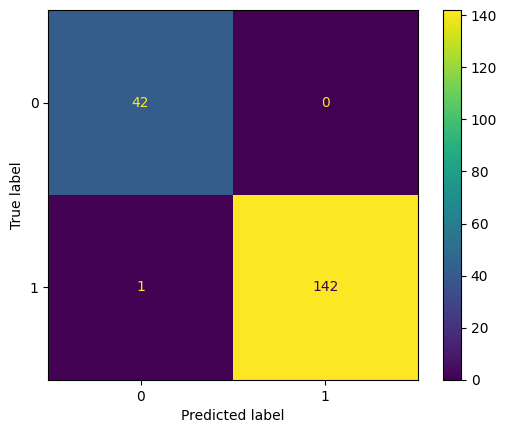

In [146]:
# Run the model on the validation data

y_pred = svm_over.predict(x_valid_bin)

report_on_valid = classification_report(y_valid, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        50
           1       1.00      0.97      0.99       174

    accuracy                           0.98       224
   macro avg       0.95      0.99      0.97       224
weighted avg       0.98      0.98      0.98       224



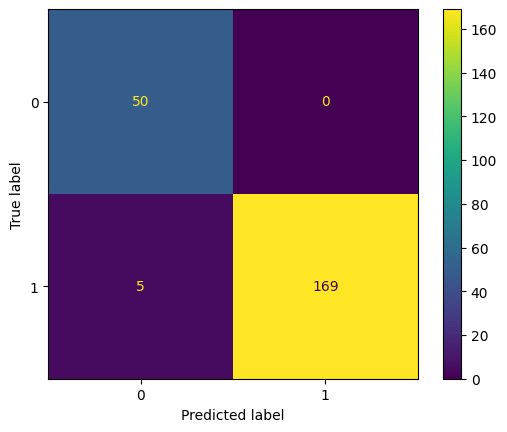

In [147]:
# Run the model on the test data

y_pred = svm_over.predict(x_test_bin)

report_on_test = classification_report(y_test, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [148]:
acc_on_valid = report_on_valid["accuracy"]
acc_on_valid

acc_on_test = report_on_test["accuracy"]
acc_on_test

print(f"The accuracy score difference between testing and validation datasets is: {round(acc_on_test - acc_on_valid, 6)}")

The accuracy score difference between testing and validation datasets is: -0.016916


#### Support Vector Machine with SMOTE Data

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.99      1.00       143

    accuracy                           0.99       185
   macro avg       0.99      1.00      0.99       185
weighted avg       0.99      0.99      0.99       185



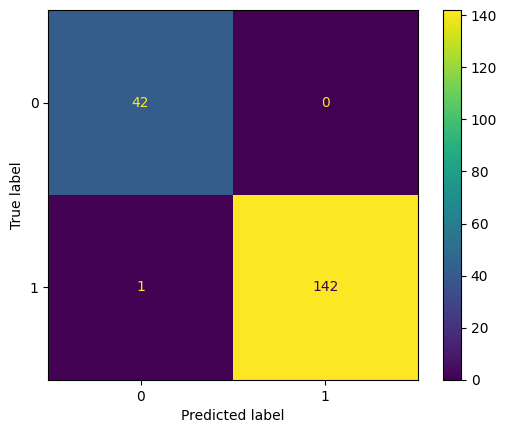

In [149]:
# Run the model on the validation data

y_pred = svm_smote.predict(x_valid_bin)

report_on_valid = classification_report(y_valid, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        50
           1       1.00      0.97      0.99       174

    accuracy                           0.98       224
   macro avg       0.95      0.99      0.97       224
weighted avg       0.98      0.98      0.98       224



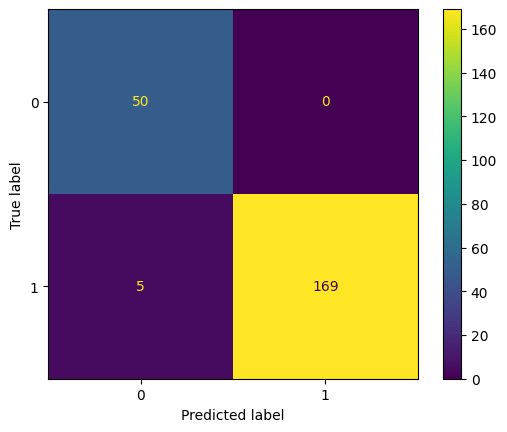

In [150]:
# Run the model on the test data

y_pred = svm_smote.predict(x_test_bin)

report_on_test = classification_report(y_test, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [151]:
acc_on_valid = report_on_valid["accuracy"]
acc_on_valid

acc_on_test = report_on_test["accuracy"]
acc_on_test

print(f"The accuracy score difference between testing and validation datasets is: {round(acc_on_test - acc_on_valid, 6)}")

The accuracy score difference between testing and validation datasets is: -0.016916


#### Decision Tree Classifier with Oversampling Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       143

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185



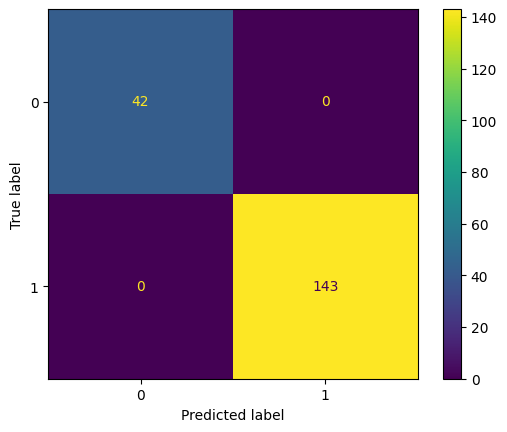

In [152]:
# Run the model on the validation data

y_pred = dct_over.predict(x_valid_bin)

report_on_valid = classification_report(y_valid, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.96      0.93        50
           1       0.99      0.97      0.98       174

    accuracy                           0.97       224
   macro avg       0.95      0.97      0.96       224
weighted avg       0.97      0.97      0.97       224



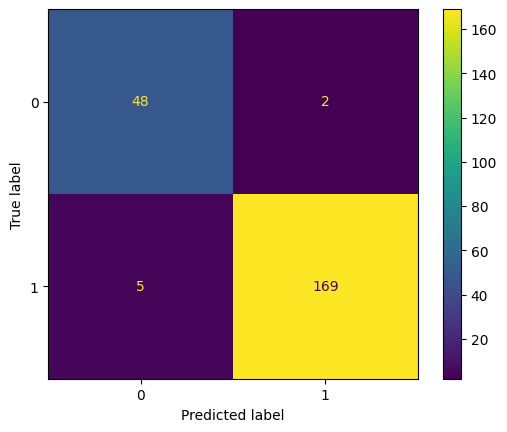

In [153]:
# Run the model on the test data

y_pred = dct_over.predict(x_test_bin)

report_on_test = classification_report(y_test, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [154]:
acc_on_valid = report_on_valid["accuracy"]
acc_on_valid

acc_on_test = report_on_test["accuracy"]
acc_on_test

print(f"The accuracy score difference between testing and validation datasets is: {round(acc_on_test - acc_on_valid, 6)}")

The accuracy score difference between testing and validation datasets is: -0.03125


#### Decision Tree Classifier with SMOTE Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       143

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185



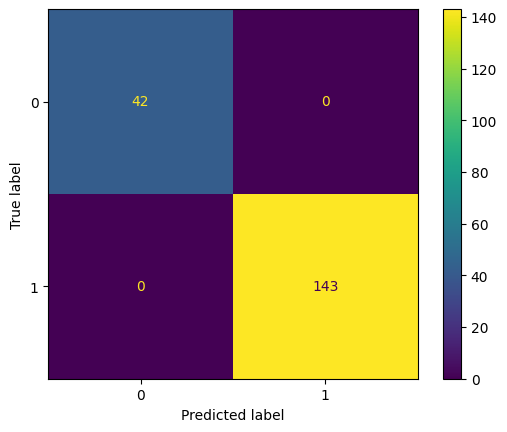

In [155]:
# Run the model on the validation data

y_pred = dct_smote.predict(x_valid_bin)

report_on_valid = classification_report(y_valid, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.96      0.93        50
           1       0.99      0.97      0.98       174

    accuracy                           0.97       224
   macro avg       0.95      0.97      0.96       224
weighted avg       0.97      0.97      0.97       224



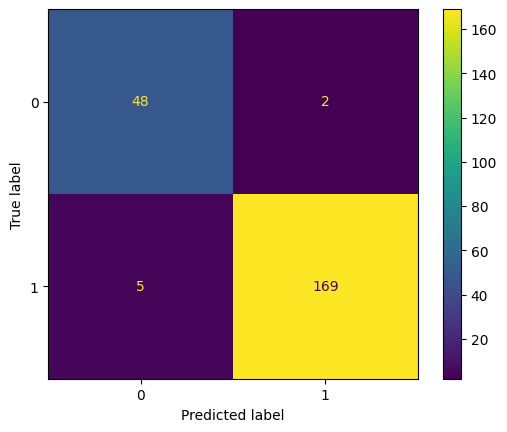

In [156]:
# Run the model on the test data

y_pred = dct_smote.predict(x_test_bin)

report_on_test = classification_report(y_test, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [157]:
acc_on_valid = report_on_valid["accuracy"]
acc_on_valid

acc_on_test = report_on_test["accuracy"]
acc_on_test

print(f"The accuracy score difference between testing and validation datasets is: {round(acc_on_test - acc_on_valid, 6)}")

The accuracy score difference between testing and validation datasets is: -0.03125


In credit card approval prediction, it is crucial to predict correctly the **accuracy score**, which means the machine learning model is able to predict the approval status of the applications as approved that originally got approved, and vice versa.

If the defect in credit card approval prediction can be kept at a very low level, the credit card issuer will not have a problem handling the credit default status.

In [ ]:
report_on_valid = classification_report(y_valid, y_pred, output_dict = True)
acc_on_valid = report_on_valid["accuracy"]

print(f"The accuracy score on validation datasets is: {round(acc_on_valid, 6)},\nwhich is considered a high score")

The accuracy score on validation datasets is: 1.0,
which is considered a high score


## Conclusion

In credit card approval prediction, it is crucial to predict correctly the **accuracy score**, which means the machine learning model is able to predict the approval status of the applications as approved that originally got approved, and vice versa.


If the defect in credit card approval prediction can be kept at a very low level, the credit card issuer will not have a problem handling the credit default status.

Both of the algorithm used to train the model, Support Vector Machine (SVM) and Decision Tree Classifier(DTC), have a decreased accuracy score when running the test dataset compare to the validation dataset.

The difference in the SVM algorithm is smaller, so it means the algorithm is more stable than the other.

Even the training time for SVM is not the fastest one, I decide to choose the model stability than the speed.

The oversampling data configuration results the faster training time, so I decide to use the **SVM with oversampling data** configuration to bulid the machine learning model in this problem.

In [158]:
# Save the best model
utils.pkl_dump(best_model, config["production_model_path"])
